# Milestone Project 1: Food Vision Big

See the annoted version of this notebook on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/07_food_vision_milestone_project_1.ipynb

# Check GPU

Using mixed precision training we need a GPU with score 7.0+ (see here: https://developer.nvidia.com/cuda-gpus)

## Get helper functions 

In past modules, we've created a bunch of different helper functions to do small tasks required for our notebooks.

Rather than rewrite all of these, we can import a script and load them in from there.

The script we've got avialable can be found on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py


In [1]:
# Download helper_function script
# !wget -P ./Extras/ https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

In [2]:
# import series of helper functions for the notebook
from Extras.helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use Tensorflow Datasets to download data

If you want to get an overview of TensorFlow Datasets (tfds), read the guide: https://www.tensorflow.org/datasets

In [3]:
# get TensorFlow Datasets
import tensorflow as tf
import tensorflow_datasets as tfds

In [4]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is our target dataset available?

True


In [5]:
# Load in the data
(train_data, test_data), ds_info = tfds.load(name = "food101",
                                             split = ["train[:75%]", "train[25%:]"],
                                             shuffle_files = True,
                                             as_supervised = True, # Datasets gets returned in tuple format
                                             with_info = True,
                                             data_dir = "./Data")   

In [6]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    version=1.0.0,
    description='This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.',
    urls=['http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz'],
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
    }),
    total_num_examples=101000,
    splits={
        'train': 101000,
    },
    supervised_keys=('image', 'label'),
    citation="""@inproceedings{bossard14,
      title = {Food-101 -- Mining Discriminative Components with Random Forests},
      author = {Bossard, Lukas and Guilla

In [8]:
# features of Food101 from tfds
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [9]:
# get the class names 
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Explore the Food101 data from Tensorflow Dataset

To become one with data, we want to find:

* class names
* The shape of our input tensor (image tensor)
* The datatype of our input data
* What the labels look like (e.g are they one-hot-encoded or are they label encoded)
* Do the labels match up with the class names ?

In [28]:
# Take one sample of training data
train_one_sample = train_data.take(1) # samples are in the format (image_tensor, label)

In [29]:
# What does one sample of our data look like ?
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [30]:
# Output info about our training sample
for image, label in train_one_sample:
    print(f"""
        Image Shape: {image.shape}
        Image Datatype: {image.dtype}
        Target class from Food101 (tensor form): {label}
        Class name (str form): {class_names[label.numpy()]}
        """)


        Image Shape: (512, 512, 3)
        Image Datatype: <dtype: 'uint8'>
        Target class from Food101 (tensor form): 35
        Class name (str form): escargots
        


In [31]:
# What does our image tensor from TFDS's Food101 look like
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[189, 180, 175],
        [191, 182, 177],
        [192, 183, 178],
        ...,
        [ 72,  62,  86],
        [ 87,  79, 103],
        [ 93,  85, 109]],

       [[194, 185, 180],
        [196, 187, 182],
        [196, 187, 182],
        ...,
        [ 81,  71,  95],
        [ 93,  85, 109],
        [ 97,  89, 113]],

       [[197, 188, 183],
        [199, 190, 185],
        [199, 190, 185],
        ...,
        [ 92,  82, 106],
        [102,  94, 118],
        [105,  97, 121]],

       ...,

       [[114, 110, 111],
        [112, 108, 109],
        [110, 106, 107],
        ...,
        [133, 160, 187],
        [138, 165, 192],
        [143, 170, 197]],

       [[106, 100, 102],
        [105,  99, 101],
        [102,  96, 100],
        ...,
        [141, 168, 195],
        [145, 172, 199],
        [148, 175, 202]],

       [[108, 102, 104],
        [109, 103, 105],
        [107, 101, 105],
        ...,
        [134, 161, 18

In [32]:
# What are the min and max values of our image tensor
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an image from TensorFlow Datasets

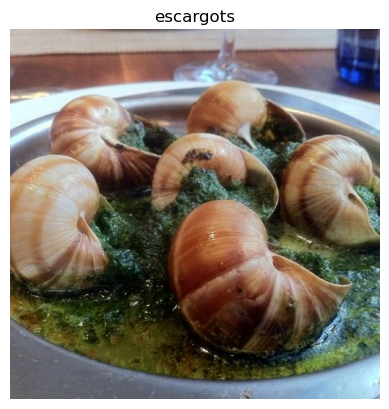

In [33]:
# plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify the label to which it is assiciated
plt.axis(False);

## Create preprocessesing functions for our data

Neural networks perform best when data is in a certain way (e.g batched, normalized, etc).

However, not all data (including data from TensorFlow Datasets) comes like this.

So, in order to get it ready for a neural network, you'll often have to write proprocessing functions and map it to your data.

What we know about our data:

* In `uint8` datatype
* comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 and 255)

What we know model like:

* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* For batches, TensorFlow likes all of our tensors within a batch to be of the same size
* Scaled (values between 0 and 1) also called normalized tensors generally performs better

With these points in mind, we've got a few things we can tackle with a preprocessing function.

Since we're going to use EfficientNetBX pretrained model from tf.keras.applications we don't need to rescale our data (these architecture have rescaling built-in).

This means our functions need to:

* Reshape our images to all the same size
* Convert the dtype of our images tensors from `unit8` to `float32`

In [38]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape = 224):
    """
    Converts image datatype from 'unit8' -> 'float32' and reshapes image to [img_shape, img_shape, color_channels]
    """
    # image = image/255 # nor required with EfficientNetBX from tf.keras.applications.EfficientNetBX
    image = tf.image.resize(image, [img_shape, img_shape])
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [39]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before proprocessing: \n {image[:2]}..., \nShape: {image.shape}, \nDatatype: {image.dtype}")
print(f"Image after preprocessing: \n {preprocessed_img[:2]}..., \nShape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}")


Image before proprocessing: 
 [[[189 180 175]
  [191 182 177]
  [192 183 178]
  ...
  [ 72  62  86]
  [ 87  79 103]
  [ 93  85 109]]

 [[194 185 180]
  [196 187 182]
  [196 187 182]
  ...
  [ 81  71  95]
  [ 93  85 109]
  [ 97  89 113]]]..., 
Shape: (512, 512, 3), 
Datatype: <dtype: 'uint8'>
Image after preprocessing: 
 [[[193.5      184.5      179.5     ]
  [192.38264  183.38264  178.38264 ]
  [197.86224  188.86224  183.86224 ]
  ...
  [ 51.07648   38.862217  60.43369 ]
  [ 59.811478  49.811478  73.81148 ]
  [ 92.54098   84.54098  108.54098 ]]

 [[198.61734  189.61734  184.61734 ]
  [198.86734  189.86734  184.86734 ]
  [201.12755  192.12755  187.12755 ]
  ...
  [ 64.87245   52.658184  74.22966 ]
  [ 74.15835   64.15835   88.15835 ]
  [ 99.42367   91.42367  115.42367 ]]]..., 
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>


## Batch and prepare dataset

We're going to make our data inputs really fast.

For more resources on this, the following guide is hight recomended: https://www.tensorflow.org/guide/data_performance

In [40]:
# Map preprocessing functions to tranining (and parallelize)
train_data = train_data.map(map_func = preprocess_img, num_parallel_calls = tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size = 1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(map_func = preprocess_img, num_parallel_calls = tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [41]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)